#**Material Didático: Criando um Sistema de Recomendação Explicável (XRS)**

**Objetivo:** Sair da "Caixa-Preta".

Neste notebook, vamos explorar três abordagens diferentes de Sistemas de Recomendação Explicáveis (XRS – Explainable Recommender Systems), aplicando cada uma delas sobre o conjunto de dados MovieLens 100k.
Vamos mostrar como diferentes modelos de recomendação podem gerar explicações distintas, ajudando o usuário a entender por que determinado item foi recomendado.

Trabalharemos com três tipos de XRS:

##***1. XRS Baseado em Vizinhança (Neighborhood-based XRS)***

Utiliza similaridade entre itens para justificar a recomendação.
Exemplo:

*“Recomendamos este filme porque ele é parecido com outros filmes que você assistiu e avaliou bem.”*

Esse método é construído sobre um modelo colaborativo (ItemKNN) que encontra itens semelhantes e usa esses vizinhos como evidência.

##***2. XRS Baseado em Conteúdo (Content-based XRS)***

Explica a recomendação com base em atributos do item — no nosso caso, gêneros dos filmes.
Exemplo:

*“Recomendamos este filme porque ele compartilha os gêneros A, B e C com filmes que você gostou.”*

Aqui usamos o ItemAttributeKNN, que considera explicitamente metadados (gêneros) para recomendar e explicar.

##***3. XRS Pós-Hoc ou Agnóstico ao Modelo (Post-hoc / Model-Agnostic XRS)***

O modelo principal (BPRMF) faz a recomendação, mas a explicação é construída separadamente, usando informação interpretável.
Exemplo:

*“Este filme foi recomendado porque ele tem a maior similaridade de gêneros com filmes que você avaliou positivamente.”*

Esse tipo de explicação é independente do modelo de recomendação, funcionando como uma camada interpretável sobre um sistema de fatores latentes.

Ao longo do notebook, vamos treinar cada modelo, gerar recomendações para um usuário e produzir explicações claras e intuitivas, demonstrando como os diferentes tipos de XRS podem ajudar a tornar sistemas de recomendação mais transparentes, confiáveis e interpretáveis.

**Ferramentas que usaremos:**
* **Dataset:** MovieLens 100k (um dataset público clássico).
* **Recomendação:** Biblioteca `CaseRecommender`
* **Explicação:** Bibliotecas `Pandas` e `Numpy`

## **SEÇÃO 1: *Setup e Instalação***

### 🧹 **Preparação dos Dados (MovieLens 100k)**

Nesta seção, carregamos o dataset MovieLens 100k e realizamos o pré-processamento inicial.

O objetivo é:
- Carregar avaliações de filmes pelos usuários.
- Carregar a lista de filmes e seus gêneros.
- Unificar os dados em um formato adequado para os modelos da biblioteca CaseRecommender.
- Criar subconjuntos de treino e teste, utilizando a divisão 80/20.

Esses arquivos processados serão utilizados nos três tipos de Sistemas de Recomendação Explicáveis (XRS) implementados no notebook.


In [43]:
# ------------------------------------------------------
# 1) Importar alguams das bibliotecas que utilizaremos
# ------------------------------------------------------

import pandas as pd
import numpy as np
import sys
!{sys.executable} -m pip install caserecommender
!pip install wget
import wget

np.random.seed(42)
random.seed(42)

In [11]:
# ------------------------------------------------------
# 2) Baixar o dataset "MovieLens 100k"
# ------------------------------------------------------

!python3 -m wget https://files.grouplens.org/datasets/movielens/ml-100k.zip -q
!unzip ml-100k.zip -d ml-100k
!mv ml-100k/ml-100k/* .


Usage: wget.py [options]

wget.py: error: no such option: -q
Archive:  ml-100k.zip
   creating: ml-100k/ml-100k/
  inflating: ml-100k/ml-100k/allbut.pl  
  inflating: ml-100k/ml-100k/mku.sh  
  inflating: ml-100k/ml-100k/README  
  inflating: ml-100k/ml-100k/u.data  
  inflating: ml-100k/ml-100k/u.genre  
  inflating: ml-100k/ml-100k/u.info  
  inflating: ml-100k/ml-100k/u.item  
  inflating: ml-100k/ml-100k/u.occupation  
  inflating: ml-100k/ml-100k/u.user  
  inflating: ml-100k/ml-100k/u1.base  
  inflating: ml-100k/ml-100k/u1.test  
  inflating: ml-100k/ml-100k/u2.base  
  inflating: ml-100k/ml-100k/u2.test  
  inflating: ml-100k/ml-100k/u3.base  
  inflating: ml-100k/ml-100k/u3.test  
  inflating: ml-100k/ml-100k/u4.base  
  inflating: ml-100k/ml-100k/u4.test  
  inflating: ml-100k/ml-100k/u5.base  
  inflating: ml-100k/ml-100k/u5.test  
  inflating: ml-100k/ml-100k/ua.base  
  inflating: ml-100k/ml-100k/ua.test  
  inflating: ml-100k/ml-100k/ub.base  
  inflating: ml-100k/ml-100k

In [12]:
# ------------------------------------------------------
# 3) Avaliando os gêneros presentes no Dataset
# ------------------------------------------------------

genre = pd.read_csv('u.genre', sep="|", encoding='latin-1', header=None)
genre.drop(genre.columns[1], axis=1, inplace=True)
genre.columns = ['Genres']
genre_list = list(genre['Genres'])
genre_list

['unknown',
 'Action',
 'Adventure',
 'Animation',
 "Children's",
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [13]:
# ------------------------------------------------------
# 4) Avaliando as notas presentes no Dataset
# ------------------------------------------------------

data = pd.read_csv('u.data', sep="\t", header=None)
data.columns = ['userId', 'movieId', 'rating', 'timestamp']
data.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [15]:
# ------------------------------------------------------
# 5) Avaliando as informações dos filmes no Dataset
# ------------------------------------------------------

item = pd.read_csv('u.item', sep="|", encoding='latin-1', header=None)
item.columns = ['movieId', 'title' ,'release','video release date', 'IMDb URL', 'unknown', 'Action',
                'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
                'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item['release'] = pd.to_datetime(item['release'])
item = item[pd.notnull(item['release'])]
item['year'] = item['release'].dt.year.astype(int)
item.drop(columns=['release', 'video release date', 'IMDb URL'], inplace=True)
item.head()

,movieId,title,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1995
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1995
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1995


In [16]:
# ------------------------------------------------------
# 6) Preparando os metadados dos filmes
# ------------------------------------------------------
df_meta = item.melt(id_vars=['movieId', 'title'], var_name='genre') # O método melt() transforma colunas em linhas
df_meta = df_meta[df_meta.value == 1] # Só ficam linhas onde o gênero é marcado como 1
df_meta.drop(columns=['value'], inplace=True) # Remove a coluna auxiliar “value”
df_meta.head() # Tabela abaixo

,movieId,title,genre
1371,1373,Good Morning (1971),unknown
1682,2,GoldenEye (1995),Action
1684,4,Get Shorty (1995),Action
1697,17,From Dusk Till Dawn (1996),Action
1701,21,Muppet Treasure Island (1996),Action


In [18]:
# ------------------------------------------------------
# 7) Avaliando as informações dos usuários no Dataset
# ------------------------------------------------------

user = pd.read_csv('u.user', sep="|", encoding='latin-1', header=None)
user.columns = ['userId', 'age', 'gender', 'occupation', 'zip code']
user.head()

,userId,age,gender,occupation,zip code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


## **SEÇÃO 2: *Trabalhando o XRS***

##**Seção 2.1 — XRS Baseado em Vizinhança (Neighborhood-based XRS)**

Nesta seção, vamos trabalhar com um modelo colaborativo baseado em vizinhança entre itens (ItemKNN). A ideia é simples: identificar filmes semelhantes ao que o usuário já avaliou bem e usar essa relação como explicação. Aqui, a recomendação surge a partir de padrões de comportamento coletivo, e a explicação reflete justamente essas similaridades entre itens que o usuário conhece.

A ideia do XRS aqui é:

*“Este filme é recomendado porque é parecido com outros filmes que você avaliou bem.”*

Etapas desta seção:
1. Treinar o modelo ItemKNN.
2. Escolher um usuário aleatório.
3. Obter o filme mais recomendado para esse usuário.
4. Identificar os filmes semelhantes que o usuário já gostou.
5. Construir uma explicação clara baseada em vizinhança de itens.

In [44]:
# ------------------------------------------------------
# 1) Carregando e preparando os dados
# ------------------------------------------------------

import os
import random
from sklearn.model_selection import train_test_split
from caserec.recommenders.item_recommendation.itemknn import ItemKNN
from caserec.recommenders.item_recommendation.item_attribute_knn import ItemAttributeKNN
from caserec.recommenders.item_recommendation.bprmf import BprMF
np.asfarray = np.asarray # Deficiência do CaseRec

# Carregando os ratings
ratings_cols = ['userId', 'movieId', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# Carregando os títulos
items_cols = ['movieId', 'title', 'release date', 'video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
              'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
              'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items = pd.read_csv('u.item', sep='|', names=items_cols, encoding='latin-1')

In [20]:
# ------------------------------------------------------
# 2) Preparando o dataset para o CaseRecommender
# ------------------------------------------------------

# 80% treino e 20% teste
train_df, test_df = train_test_split(ratings, test_size=0.2, random_state=42)

# Salvando em .dat pro caserec
train_df.to_csv('train.dat', sep='\t', header=False, index=False)
test_df.to_csv('test.dat', sep='\t', header=False, index=False)

In [21]:
# ------------------------------------------------------
# 3) Rodando o ItemKNN e gerando recomendações
# ------------------------------------------------------

recommender = ItemKNN('train.dat', 'test.dat', output_file='test.dat_recs.dat', as_binary=True)
recommender.compute()

# salvando em 'test.dat_recs.dat'
recs_df = pd.read_csv('test.dat_recs.dat', sep='\t', header=None, names=['userId', 'movieId', 'score'])

[Case Recommender: Item Recommendation > ItemKNN Algorithm]

train data:: 943 users and 1653 items (80000 interactions) | sparsity:: 94.87%
test data:: 940 users and 1411 items (20000 interactions) | sparsity:: 98.49%

training_time:: 3.060210 sec
prediction_time:: 30.721786 sec


Eval:: PREC@1: 0.470213 PREC@3: 0.412411 PREC@5: 0.375745 PREC@10: 0.320532 RECALL@1: 0.030879 RECALL@3: 0.082292 RECALL@5: 0.123371 RECALL@10: 0.201672 MAP@1: 0.470213 MAP@3: 0.57234 MAP@5: 0.567162 MAP@10: 0.525749 NDCG@1: 0.470213 NDCG@3: 0.664738 NDCG@5: 0.660237 NDCG@10: 0.642773 


🔍 Encontrando a Evidência para a Explicação

Agora analisamos a matriz de similaridade entre itens aprendida pelo ItemKNN.

Passos:
1. Localizamos filmes que o usuário avaliou com nota ≥ 4.
2. Verificamos quais desses filmes estão mais próximos do filme recomendado.
3. Selecionamos o filme mais similar como "evidência".
4. Geramos uma explicação do tipo:  

*“Recomendamos X porque é parecido com Y, que você avaliou bem.”*

In [25]:
# ------------------------------------------------------
# 4) Gerando a explicação para um usuário aleatório
# ------------------------------------------------------

# Pegando um usuário aleatório
random_user_id = random.choice(test_df['userId'].unique())

# Top 5 rec
user_recs = recs_df[recs_df['userId'] == random_user_id].head(5)

# Explicando o top 1
if not user_recs.empty:
    top_rec_movie_id = user_recs.iloc[0]['movieId']
    recommended_movie_title = items[items['movieId'] == top_rec_movie_id]['title'].values[0]

    # Lógica da explicação

    # 1. Pegando todos os filmes que o usuário avaliou com nota alta (rating >= 4) no training set
    user_high_ratings = train_df[(train_df['userId'] == random_user_id) & (train_df['rating'] >= 4)]

    # 2. Pegar os top 10 itens mais similares (vizinhos) ao filme recomendado
    if top_rec_movie_id in recommender.item_to_item_id:
        # pegar o índice interno do item
        item_idx = recommender.item_to_item_id[top_rec_movie_id]

        # vetor de similaridades com todos os outros itens
        sims = recommender.si_matrix[item_idx]

        # obter os índices dos top 10 mais similares (excluindo o próprio item)
        similar_indices = sims.argsort()[::-1][1:11]

        # converter de volta para IDs reais dos filmes
        similar_items = [recommender.item_id_to_item[i] for i in similar_indices]
    else:
        similar_items = []


    # 3. Achar quais dos itens similares o usuário também avaliou com nota alta
    explanation_items = user_high_ratings[user_high_ratings['movieId'].isin(similar_items)]

    # Printando
    print(f"Análise para o usuário de ID: {random_user_id}\n")
    print(f"Recomendação: '{recommended_movie_title}'\n")
    print("------------------------- Explicação -------------------------")

    if not explanation_items.empty:
        print("Essa recomendação é baseada em outros filmes similares que você gostou:\n")
        for index, row in explanation_items.iterrows():
            item_id = row['movieId']
            rating = row['rating']
            title = items[items['movieId'] == item_id]['title'].values[0]
            print(f"  - Você avaliou '{title}' com nota {rating}/5.")
    else:
        print("Nós estamos recomendando esse filme porque é popular entre os usuários com gosto parecido ao seu.")
    print("-----------------------------------------------------------------")

else:
    print(f"Não foi possível gerar recomendação ao usuário de ID {random_user_id}.")

Análise para o usuário de ID: 122

Recomendação: 'Like Water For Chocolate (Como agua para chocolate) (1992)'

------------------------- Explicação -------------------------
Essa recomendação é baseada em outros filmes similares que você gostou:

  - Você avaliou 'Remains of the Day, The (1993)' com nota 5/5.
  - Você avaliou 'Amadeus (1984)' com nota 5/5.
  - Você avaliou 'Unbearable Lightness of Being, The (1988)' com nota 5/5.
  - Você avaliou 'Lawrence of Arabia (1962)' com nota 5/5.
  - Você avaliou 'Piano, The (1993)' com nota 5/5.
  - Você avaliou 'Four Weddings and a Funeral (1994)' com nota 5/5.
-----------------------------------------------------------------


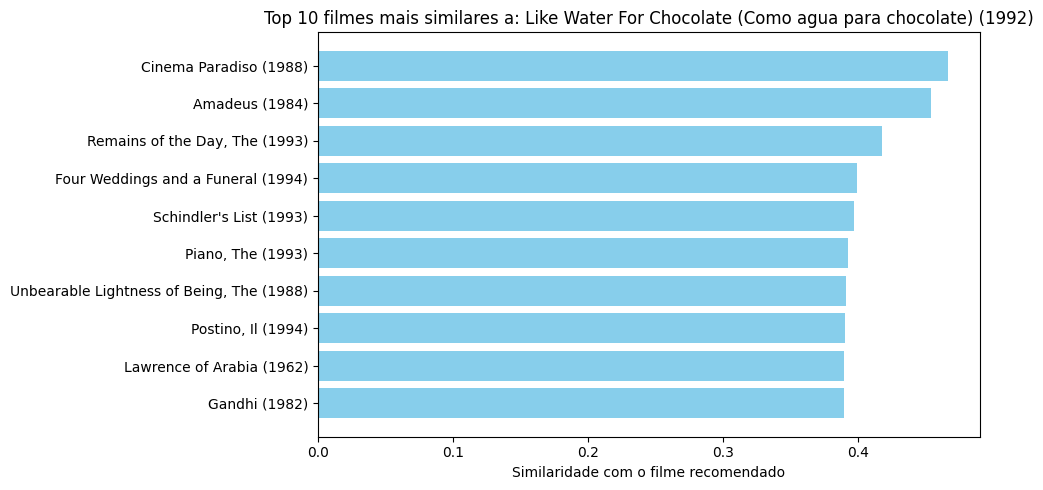

In [26]:
# ------------------------------------------------------
# 5) Visualização com gráfico
# ------------------------------------------------------

import matplotlib.pyplot as plt

if top_rec_movie_id in recommender.item_to_item_id:
    item_idx = recommender.item_to_item_id[top_rec_movie_id]
    sims = recommender.si_matrix[item_idx]

    similar_indices = sims.argsort()[::-1][1:11]
    similar_scores = sims[similar_indices]
    similar_items = [recommender.item_id_to_item[i] for i in similar_indices]

    # Pegar os títulos dos filmes
    similar_titles = [items.loc[items['movieId'] == mid, 'title'].values[0] for mid in similar_items]

    # Plotar
    plt.figure(figsize=(10, 5))
    plt.barh(similar_titles[::-1], similar_scores[::-1], color='skyblue')
    plt.xlabel("Similaridade com o filme recomendado")
    plt.title(f"Top 10 filmes mais similares a: {recommended_movie_title}")
    plt.tight_layout()
    plt.show()


##**Seção 2.2 — XRS Baseado em Conteúdo (Content-based XRS)**

Agora vamos explorar recomendações explicadas pelos atributos dos filmes, especialmente os gêneros. Com o ItemAttributeKNN, conseguimos justificar a recomendação mostrando quais características do item recomendado se conectam aos itens que o usuário gostou. Esse tipo de XRS é ideal quando queremos explicações mais intuitivas e diretamente ligadas ao conteúdo do item.

A ideia principal é:

*“Este filme foi recomendado porque compartilha gêneros com outros filmes que você gostou.”*

Etapas desta seção:
1. Garantir que os metadados (`movie_genres.txt`) contenham apenas filmes presentes no treino.
2. Treinar o ItemAttributeKNN com base nos atributos (gêneros).
3. Gerar recomendações para um usuário.
4. Encontrar o filme mais similar em termos de gêneros.
5. Criar a explicação usando os gêneros compartilhados.

In [37]:
# ------------------------------------------------------
# 1) Criar o arquivo de metadados para a caserec
#    (apenas itens que aparecem no train.dat)
# ------------------------------------------------------

# Itens que aparecem no conjunto de treino
itens_treino = train_df['movieId'].unique()

# Filtra o df_meta para manter só filmes que estão no treino
df_meta_train = df_meta[df_meta['movieId'].isin(itens_treino)]

# Gera o arquivo de metadados no formato esperado pelo CaseRecommender
df_meta_train[['movieId', 'genre']].to_csv(
    'movie_genres.txt',
    sep='\t',
    header=False,
    index=False
)

# Usuário aleatório
random_user_id = user['userId'].sample(1).iloc[0]
print(f"\nUsuário selecionado: {random_user_id}")

# ------------------------------------------------------
# 2) ItemAttributeKNN
# ------------------------------------------------------

recommender_attr = ItemAttributeKNN(
    train_file='train.dat',
    metadata_file='movie_genres.txt',
    sep='\t'
)
recommender_attr.compute()

# Filtrar a lista de ranking para pegar as recomendações do usuário
all_rankings_attr = recommender_attr.ranking
user_recommendations_attr = []
for user_id_rank, movie_id_rank, score_rank in all_rankings_attr:
    if user_id_rank == random_user_id:
        user_recommendations_attr.append((movie_id_rank, score_rank))

if not user_recommendations_attr:
    print(f"Nenhuma recomendação encontrada para o usuário {random_user_id}.")
else:

    '''

    🎭 Encontrando Evidência Baseada em Gêneros

      Aqui buscamos um filme que o usuário avaliou bem e que compartilhe gêneros com o filme recomendado.

      Passos:
        1. Obtemos os gêneros do filme recomendado.
        2. Para cada filme que o usuário gostou, verificamos sobreposição de gêneros.
        3. Selecionamos o filme com maior similaridade semântica (mesmos gêneros).
        4. A explicação final segue o formato: “Recomendamos X pois ele compartilha os gêneros A, B, C com o filme Y, que você avaliou positivamente.”

    '''

    # ----------------------------------------------------------------------------------------
    # 3) Filme "mais recomendado" e todos os filmes que o usuário avaliou com nota alta (>= 4)
    # ----------------------------------------------------------------------------------------

    movie_X_id, score = user_recommendations_attr[0]
    movie_X_title = item.loc[item['movieId'] == movie_X_id, 'title'].iloc[0]

    # Filmes que o usuário avaliou bem (>= 4)
    user_high_rated_movies = data[
        (data['userId'] == random_user_id) &
        (data['rating'] >= 4)
    ]

    best_explanation = {'movie_Y_id': None, 'similarity': -1}

    try:
        # Índice interno do filme recomendado na estrutura do CaseRecommender
        movie_X_idx = recommender_attr.items.index(movie_X_id)

        # Iterar sobre os filmes que o usuário gostou para encontrar o mais similar
        for rated_movie_id in user_high_rated_movies['movieId']:

            # 🔑 Ignora o próprio filme recomendado para evitar similaridade 1.0 trivial
            if rated_movie_id == movie_X_id:
                continue

            # Verifica se o filme avaliado está na lista de itens do modelo
            if rated_movie_id in recommender_attr.items:
                # Índice interno do filme avaliado
                rated_movie_idx = recommender_attr.items.index(rated_movie_id)

                # Acessa a similaridade na matriz si_matrix
                similarity = recommender_attr.si_matrix[movie_X_idx][rated_movie_idx]

                # Guarda o filme com a maior similaridade encontrada até agora
                if similarity > best_explanation['similarity']:
                    best_explanation['movie_Y_id'] = rated_movie_id
                    best_explanation['similarity'] = similarity

    except (ValueError, IndexError):
        print("Não foi possível processar a recomendação para encontrar uma explicação.")

    # ------------------------------------------------------
    # 4) Explicação final e Print
    # ------------------------------------------------------

    if best_explanation['movie_Y_id']:
        movie_Y_id = best_explanation['movie_Y_id']
        movie_Y_title = item.loc[item['movieId'] == movie_Y_id, 'title'].iloc[0]

        similarity_score = best_explanation['similarity']

        # Usar a versão filtrada dos metadados (df_meta_train)
        genres_X = set(df_meta_train[df_meta_train['movieId'] == movie_X_id]['genre'])
        genres_Y = set(df_meta_train[df_meta_train['movieId'] == movie_Y_id]['genre'])

        # Gêneros em comum
        common_genres = list(genres_X.intersection(genres_Y))
        if len(common_genres) > 1:
            genres_str = ", ".join(common_genres[:-1]) + " e " + common_genres[-1]
        else:
            genres_str = common_genres[0] if common_genres else "gêneros em comum"

        # Printando
        print(f"Valor da Similaridade (ItemAttributeKNN): {similarity_score:.2f}")
        print("\n------------------------- Explicação ----------------------------")
        print(
            f"Estou te recomendando '{movie_X_title}' pois este filme possui os mesmos gêneros "
            f"({genres_str}) que o filme '{movie_Y_title}', que você já assistiu e gostou!"
        )

    else:
        print(
            f"\nRecomendação para o usuário {random_user_id}: '{movie_X_title}', "
            "mas não foi possível gerar uma explicação detalhada com base em conteúdo."
        )

    print("-----------------------------------------------------------------")



Usuário selecionado: 622
[Case Recommender: Item Recommendation > Item Attribute KNN Algorithm]

train data:: 943 users and 1653 items (80000 interactions) | sparsity:: 94.87%
training_time:: 2.656206 sec
>> metadata:: 1652 items and 19 metadata (2854 interactions) | sparsity:: 90.91%
prediction_time:: 37.400125 sec


Valor da Similaridade (ItemAttributeKNN): 1.00
------------------------- Explicação -------------------------
Estou te recomendando 'Star Trek: The Wrath of Khan (1982)' pois este filme possui os mesmos gêneros (Action, Adventure e Sci-Fi) que o filme 'Star Trek: Generations (1994)', que você já assistiu e gostou!
-----------------------------------------------------------------


**Note que a similaridade reflete apenas os gêneros informados – filmes com exatamente os mesmos gêneros podem ter similaridade 1.0, mesmo sendo diferentes em outros aspectos.**

##**Seção 2.3 — XRS Pós-Hoc / Agnóstico ao Modelo (Model-Agnostic XRS)**

Por fim, aplicaremos explicações pós-hoc em um modelo de fatores latentes (BPRMF). Aqui, o modelo principal recomenda, mas a explicação é construída separadamente — usando gêneros e similaridade Jaccard como ponte interpretável. É um exemplo prático de como criar explicações mesmo quando o modelo usado para recomendar não é, por natureza, transparente. A recomendação vem do BPRMF, mas **a explicação vem de fora do modelo**, usando uma técnica pós-hoc:

*“O modelo recomendou X; encontramos evidência para isso comparando X com filmes que você avaliou bem.”*

Etapas desta seção:
1. Treinar o BPRMF usando o arquivo `train.dat`.
2. Capturar o filme mais recomendado.
3. Comparar os gêneros desse filme com os gêneros dos filmes bem avaliados pelo usuário.
4. Calcular similaridade de Jaccard entre conjuntos de gêneros.
5. Montar uma explicação baseada na maior sobreposição semântica.


In [41]:
# ------------------------------------------------------
# 1) Rodando o modelo e pegando um usuário aleatório
# ------------------------------------------------------

recommender_bprmf = BprMF(train_file='train.dat', sep='\t')
recommender_bprmf.compute()
print("Fim do treinamento do BprMF")

random_user_id = user['userId'].sample(1).iloc[0]
print(f"\nUsuário escolhido: {random_user_id}")

# ------------------------------------------------------
# 2) Lista de ranking e recomendações do usuário
# ------------------------------------------------------

all_rankings_bprmf = recommender_bprmf.ranking
user_recommendations_bprmf = [
    (movie_id_rank, score_rank)
    for user_id_rank, movie_id_rank, score_rank in all_rankings_bprmf
    if user_id_rank == random_user_id
]

if not user_recommendations_bprmf:
    print(f"Nenhuma recomendação encontrada para o usuário {random_user_id}.")
else:
    # Pegar o filme "mais recomendado"
    movie_X_id, score = user_recommendations_bprmf[0]
    movie_X_title = item.loc[item['movieId'] == movie_X_id, 'title'].iloc[0]

    print(f"\nRecomendação para o usuário de ID {random_user_id}: '{movie_X_title}'")

    '''
    🔬 Construindo Explicação Pós-Hoc

    Como o BPRMF não oferece explicações nativamente, criamos uma lógica interpretável baseada em gêneros.

    Processo:
    1. Obter gêneros do filme recomendado.
    2. Para cada filme que o usuário avaliou bem, calcular a similaridade de Jaccard.
    3. Selecionar o filme Y com maior sobreposição de gêneros.
    4. Gerar a explicação final: “Você gostou de Y, que possui os gêneros (A, B, C), compartilhados com X. Por isso X parece uma escolha adequada.”

    Se o filme recomendado também estiver entre os filmes bem avaliados do usuário, excluímos automaticamente esse caso para evitar explicações inconsistentes.

    '''

    # ------------------------------------------------------
    # 3) Explicação (pós-hoc / agnóstica ao modelo)
    # ------------------------------------------------------

    # Gêneros do filme recomendado (X)
    genres_X = set(df_meta[df_meta['movieId'] == movie_X_id]['genre'])

    # Filmes que o usuário avaliou com nota alta (>= 4)
    user_high_rated_movies = data[
        (data['userId'] == random_user_id) &
        (data['rating'] >= 4)
    ]

    best_explanation_evidence = {
        'movie_Y_id': None,
        'jaccard_similarity': -1,
        'common_genres': []
    }

    # Iterar sobre os filmes que o usuário gostou
    for rated_movie_id in user_high_rated_movies['movieId']:

        # ✅ NÃO usar o próprio filme recomendado como evidência
        if rated_movie_id == movie_X_id:
            continue

        genres_Y_candidate = set(df_meta[df_meta['movieId'] == rated_movie_id]['genre'])

        # Se algum dos dois não tiver gêneros, não faz sentido calcular Jaccard
        if not genres_X or not genres_Y_candidate:
            continue

        # Similaridade de Jaccard entre conjuntos de gêneros
        intersection = len(genres_X.intersection(genres_Y_candidate))
        union = len(genres_X.union(genres_Y_candidate))

        if union > 0:
            jaccard_sim = intersection / union

            # Atualiza se for a melhor evidência até agora
            if jaccard_sim > best_explanation_evidence['jaccard_similarity']:
                best_explanation_evidence['movie_Y_id'] = rated_movie_id
                best_explanation_evidence['jaccard_similarity'] = jaccard_sim
                best_explanation_evidence['common_genres'] = list(
                    genres_X.intersection(genres_Y_candidate)
                )

    # ------------------------------------------------------
    # 4) Exibição final
    # ------------------------------------------------------

    if best_explanation_evidence['movie_Y_id']:
        movie_Y_id = best_explanation_evidence['movie_Y_id']
        movie_Y_title = item.loc[item['movieId'] == movie_Y_id, 'title'].iloc[0]
        common_genres = best_explanation_evidence['common_genres']

        if len(common_genres) > 1:
            genres_str = ", ".join(common_genres[:-1]) + " e " + common_genres[-1]
        else:
            genres_str = common_genres[0] if common_genres else "gêneros em comum"

        print("\n------------------------- Explicação ----------------------------")
        print(
            f"Você gostou do filme '{movie_Y_title}', logo o filme '{movie_X_title}' "
            f"foi recomendado pois possui os gêneros ({genres_str}) em comum."
        )
    else:
        print("\nNão foi possível gerar uma explicação agnóstica para esta recomendação.")

    print("-----------------------------------------------------------------")


[Case Recommender: Item Recommendation > BPRMF]

train data:: 943 users and 1653 items (80000 interactions) | sparsity:: 94.87%
training_time:: 99.328897 sec
prediction_time:: 1.134730 sec


Fim do treinamento do BprMF

Usuário escolhido: 389

Recomendação para o usuário de ID 389: 'Four Weddings and a Funeral (1994)'

------------------------- Explicação ----------------------------
Você gostou do filme 'Ninotchka (1939)', logo o filme 'Four Weddings and a Funeral (1994)' foi recomendado pois possui os gêneros (Romance e Comedy) em comum.
-----------------------------------------------------------------


# **Conclusão**

Neste notebook demonstramos três formas distintas de gerar **recomendações explicáveis (XRS)**:

- **Vizinhança (ItemKNN):** explicação baseada em filmes similares.  
- **Conteúdo (ItemAttributeKNN):** explicação baseada em gêneros compartilhados.  
- **Pós-hoc (BPRMF):** explicação independente do modelo, usando sobreposição de gêneros.

Essas abordagens ajudam a abrir a “caixa-preta” dos sistemas de recomendação, tornando-os mais interpretáveis e transparentes.

O material foi estruturado para servir como referência didática e pode ser facilmente expandido com novas métricas, atributos ou outros modelos.
